# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from agent import Agent, ReplayBuffer

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
#env = UnityEnvironment(file_name='multi_agent/Reacher.app')
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Project Solution

The solution uses a DDPG agent implemented in agent.py. 

We primarily use the multi agent environment with the following design decisions
* Gradient clipping for the critic network as descibed in the benchmark implementation at Udacity
* we collect all experiences in a shared memory and then update the agent networks multiple times
* We use a stochastic policy to decide the number of updates per epoch. On average we expect the agents to be updated every 10 epochs (np.random.randn() < 0.1)
* We use the same OU noise for all the agents (exploration) - this is not ideal as this may support some symmetry between agents, but seems to work well in practice



### Training

In [5]:
def ddpg_run(n_episodes=200, max_t=5000, buffer_size=1e5, 
             batch_size=128, gamma=0.99, tau=1e-3, lr_actor=1e-4, lr_critic=1e-3, weight_decay=1e-4):

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    
    agent = Agent(state_size=33, action_size=4, random_seed=2, 
                  replay_buffer_len=buffer_size, batch_size=batch_size, 
                  gamma=gamma, tau=tau, lr_actor=lr_actor, lr_critic=lr_critic, 
                  weight_decay=weight_decay)

    
    if num_agents > 1:
        shared_memory = ReplayBuffer(4, int(buffer_size), batch_size, 2)
    
    states = env_info.vector_observations
    actions = [agent.act(states[ix]) for ix in range(num_agents)]
    
    scores_hist = []                        
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations
        
        #for ag in agent_list:
        #    ag.reset()
        agent.reset()
        
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = [agent.act(states[ix]) for ix in range(num_agents)]
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += rewards #Adding up all rewards without discounting for evaluation
            
            damp = 1#max(40-np.mean(scores), 1)/40.0
            if num_agents == 1:
                for s,a,r,ns,d in zip(states, actions, rewards, next_states, dones):
                    agent.step(s, a, r, ns, d, damp)
            else:
                for s,a,r,ns,d in zip(states, actions, rewards, next_states, dones):
                    shared_memory.add(s, a, r, ns, d)
                for ix in range(10):
                    if len(shared_memory) > batch_size and np.random.randn() < 0.1: #stochastic update
                        _experiences = shared_memory.sample()
                        agent.step_sharedmemory(_experiences)
            
            states = next_states
  
            if np.any(dones):
                env_info = env.reset(train_mode=True)[brain_name]
                break    

        #Averaging across all agents before adding to moving window
        scores_window.append(np.mean(scores))       # save most recent score
        scores_hist.append(np.mean(scores))         # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            #print(actions)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return agent, scores_hist

##### Multi agent training run

In [8]:
agent_ddpg_multi, scores_ddpg_multi = ddpg_run(n_episodes=200, buffer_size=1e6, lr_critic=1e-4, weight_decay=0)

Episode 100	Average Score: 24.23
Episode 200	Average Score: 35.49


##### Single agent training run

In [6]:
agent_ddpg_single, scores_ddpg_single = ddpg_run(n_episodes=600, buffer_size=1e6, lr_critic=1e-4, weight_decay=0)

Episode 100	Average Score: 1.71
Episode 200	Average Score: 4.24
Episode 300	Average Score: 6.86
Episode 400	Average Score: 7.52
Episode 500	Average Score: 8.35
Episode 600	Average Score: 9.17


### Saving the results

In [12]:
torch.save(agent_ddpg_multi.actor_local.state_dict(), 'checkpoints/agent_ddpg_multi_actor_local_weights.pth')
torch.save(agent_ddpg_multi.critic_local.state_dict(), 'checkpoints/agent_ddpg_multi_critic_local_weights.pth')
torch.save(agent_ddpg_multi.actor_target.state_dict(), 'checkpoints/agent_ddpg_multi_actor_target_weights.pth')
torch.save(agent_ddpg_multi.critic_target.state_dict(), 'checkpoints/agent_ddpg_multi_critic_target_weights.pth')

In [21]:
with open('scores_ddpg_multi.txt', 'w') as f:
    for item in scores_ddpg_multi:
        f.write("%s\n" % item)

In [14]:
with open('scores_ddpg_single.txt', 'w') as f:
    for item in scores_ddpg_multi:
        f.write("%s\n" % item)
        
torch.save(agent_ddpg_single.actor_local.state_dict(), 'checkpoints/agent_ddpg_single_actor_local_weights.pth')
torch.save(agent_ddpg_single.critic_local.state_dict(), 'checkpoints/agent_ddpg_single_critic_local_weights.pth')
torch.save(agent_ddpg_single.actor_target.state_dict(), 'checkpoints/agent_ddpg_single_actor_target_weights.pth')
torch.save(agent_ddpg_single.critic_target.state_dict(), 'checkpoints/agent_ddpg_single_critic_target_weights.pth')

In [5]:
env.close()

### Results

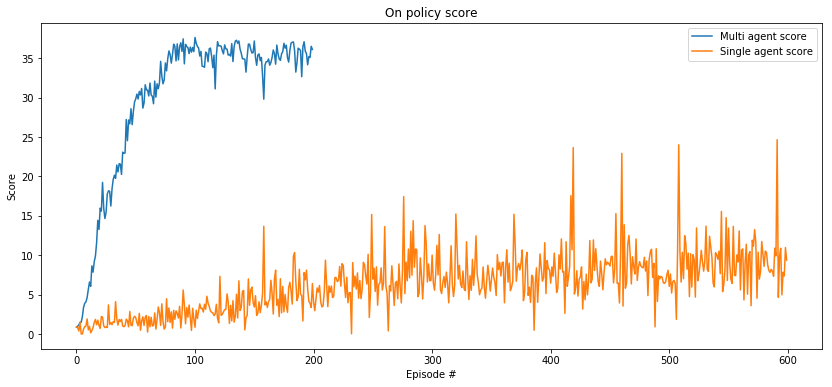

In [13]:
plt.figure(figsize=(14,6) )
plt.plot(scores_ddpg_multi, label='Multi agent score')
plt.plot(scores_ddpg_single, label='Single agent score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("On policy score")
plt.legend()
plt.show()

### Off policy score for multi-agent training

In [5]:
agent_new = Agent(state_size=33, action_size=4, random_seed=2, 
                  replay_buffer_len=1e5, batch_size=128, 
                  gamma=0.99, tau=1e-3, lr_actor=1e-4, lr_critic=1e-4, 
                  weight_decay=0)
agent_new.actor_local.load_state_dict(torch.load('checkpoints/agent_ddpg_multi_actor_local_weights.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations            # get the current state
score = 0                                          # initialize the score

while True:
    actions = agent_new.act(states,add_noise=False)                         # agent's action
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards[0]                         # get reward (for each agent)
    dones = env_info.local_done[0]                        # see if episode finished
    score += env_info.rewards[0]                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        env.close()
        break
print('Average Score of this episode: {}'.format(np.mean(score)))

Average Score of this episode: 35.59999920427799
